https://github.com/IlliaOvcharenko/lung-segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master')

In [ ]:
import torch
import torchvision
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import pdb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data loading

In [ ]:
class CXRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'cxr')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)


    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.split('.')[0] + '.png'  # Assuming mask files have the same name as the corresponding image files
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert('L') #--> image value in range [0,255]
        mask = Image.open(mask_path).convert('L') #--> mask value in range [0,255]

        if self.transform:
            image = self.transform(image)
            resized_mask = self.transform(mask)
            threshold = 0.5
            binary_mask = (resized_mask > threshold).float()
        return image, binary_mask

# Example usage:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize((0.5, 0.5), (0.5, 0.5))  # Normalize image tensors
])

dataset = CXRDataset('/content/drive/MyDrive/Projects/Pulsar-AI/Datasets/v7_cxr', transform=data_transform)

# Split the dataset into train and validation sets
train_ratio = 0.8  # Percentage of data for training
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders for train and validation sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers = 2,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers = 2,shuffle=False)

## Check dataloading

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0157, 0.0157, 0.0118,  ..., 0.0118, 0.0078, 0.0078],
         [0.0157, 0.0157, 0.0118,  ..., 0.0118, 0.0078, 0.0078],
         [0.0157, 0.0157, 0.0118,  ..., 0.0118, 0.0078, 0.0078]]])
torch.Size([1, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 256, 256])
(256, 256, 1)
(256, 256)


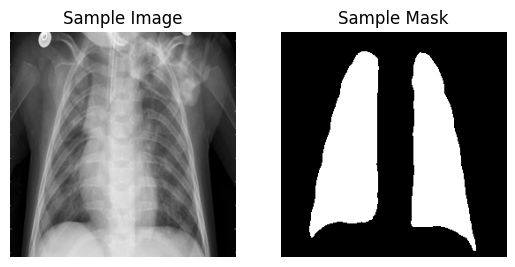

In [ ]:
import matplotlib.pyplot as plt

dataloader_check = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterate over the data loader to get the first batch (size = 1)
for images, masks in dataloader_check:
    sample_image = images[0]  # Extract the first image from the batch --> image value in range [0,1]
    sample_mask = masks[0]  # Extract the corresponding mask --> mask value in range [0,1]
    print(sample_image)
    print(sample_image.shape)
    print(sample_mask)
    print(sample_mask.shape)

    # Convert tensor to numpy array
    sample_image = sample_image.permute(1, 2, 0).numpy()
    sample_mask = sample_mask.squeeze().numpy()
    print(sample_image.shape)

    print(sample_mask.shape)

    # Denormalize the image (if it was normalized in the transforms)
    # sample_image = sample_image * 0.5 + 0.5

    # Plot the sample image and mask
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Sample Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask, cmap='gray')
    plt.title('Sample Mask')
    plt.axis('off')

    plt.show()
    break  # Stop after processing the first batch


## Model training

In [ ]:
# unet = UNet(in_channels=1, out_channels=2, batch_norm=True)
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)
unet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
  0%|          | 72.0k/507M [00:00<00:23, 23.0MB/s]


KeyboardInterrupt: ignored

In [ ]:
unet = unet.to(device)
# optimizer = torch.optim.SGD(unet.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [ ]:
train_log_filename = "train-log.txt"
epochs = 30
best_val_loss = np.inf
model_name = "unet-6v.pt"

In [ ]:
import pdb

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()

    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in train_loader:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outs = unet(origins)
        # pdb.set_trace()
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks.squeeze(1).long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * num
        print(".", end="")

    train_loss = train_loss / len(train_dataset)
    print()


    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in val_loader:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks.squeeze(1).long()).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks.squeeze(1).long(), outs.float()).item() * num
            val_dice += dice(masks.squeeze(1).long(), outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(val_dataset)
    val_jaccard = val_jaccard / len(val_dataset)
    val_dice = val_dice / len(val_dataset)
    print()


    end_t = time.time()
    spended_t = end_t - start_t

    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), '/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/modelx.pt')
            print("model saved")
            train_log_file.write("model saved\n")
        print()


train phase
...........................................................................................................................

NameError: ignored

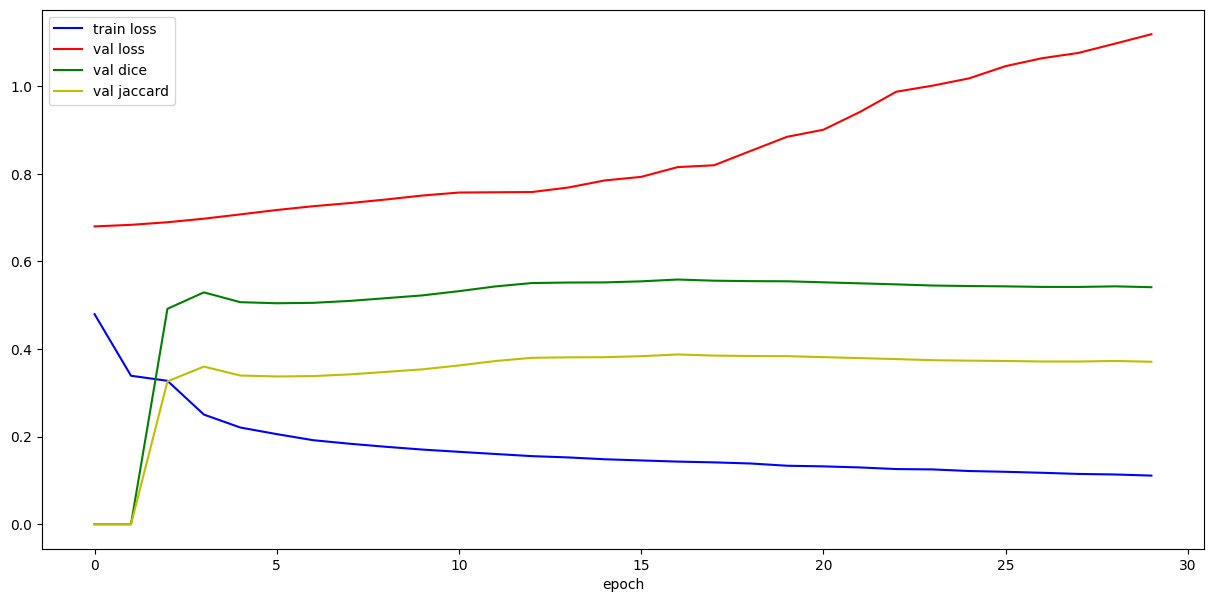

In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [ ]:
torch.cuda.empty_cache()

## Evaluate

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
 11%|█         | 54.3M/507M [00:01<00:10, 44.5MB/s]


KeyboardInterrupt: ignored

In [ ]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

In [ ]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase],
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")

plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")

## Inference


In [ ]:
from tqdm import tqdm

In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 94.6MB/s]


In [ ]:
model_name = "unet-model1.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1.pt", map_location=device))
unet.to(device)
unet.eval();

In [ ]:
device

device(type='cuda', index=0)

## Inference from GCP

In [ ]:
from google.cloud import storage
from google.oauth2 import service_account
from io import BytesIO


In [ ]:
#First, authenticate yourself as a user with access to the gcs
from google.colab import auth
auth.authenticate_user()
#This installs gcsfuse in the colab session
!echo deb http://packages.cloud.google.com/apt gcsfuse-bionic main > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse #=0.41.12 #currently using v0.41.12 because there is a bug with the most recent version
# This creates the implicit directory between the GCS and Google Drive/Colab
# We mount onto the empty GCS_Images folder because it "overwrites" any existing files in the folder
# !gcsfuse --implicit-dirs <BUCKET NAME> <COLAB DIRECTORY>
!gcsfuse --implicit-dirs veytel-cloud-store /content/drive/MyDrive/Projects/Pulsar-AI/images/GCS_Images

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k
OK
13 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 14.0 MB of archives.
After this operation, 31.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.42.5_amd64.deb ...
Unpacking gcsfuse (0.42.5) ...
Setting up gcsfuse (0.42.5) ...
I0625 21:50:49.186788 2023/06/25 21:50:49.186764 Start gcsfuse/0.42.5 (Go version go1.20.3) for app "" using mount point: /content/drive/MyDrive/Projects/Pulsar-AI/images/GCS_Images


In [ ]:
bucket = "veytel-cloud-store"
key_path = "/content/drive/MyDrive/Projects/service-account-key.json"
# Authenticate using the service account key file
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
storage_client = storage.Client(credentials=credentials)

In [ ]:
csv_path = '/content/drive/MyDrive/Projects/Pulsar-AI/images/GCS_Images/RALE-synthetic/master_csv/zero_density.csv' # the master csv that contains details of the path to the images in GCS
dir_path = '/content/drive/MyDrive/Projects/Pulsar-AI/images'  # the path where we mount the GCS images
master = pd.read_csv(csv_path)
print(len(master))

5051


## Save mask to cloud

In [ ]:
for idx in tqdm(range(len(master))):
    # Check if file extension is ".png"
    image_name_GCS = master['GCSPath'].loc[idx]
    image_path = os.path.join(dir_path, image_name_GCS)
    file_extension = os.path.splitext(image_path)[1][1:]
    if (file_extension.lower() == 'png' or file_extension.lower() == 'jpg'):
      if(file_extension.lower() == 'jpg'):
        file_extension = 'jpeg'
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      # origin1 = Image.open(image_path).convert("RGB")
      # origin1 = torchvision.transforms.functional.to_tensor(origin1)
      # height = origin1.shape[1]
      # width = origin1.shape[2]
      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          # origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          # out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          # threshold = 0.5
          # out_upsample = (out_upsample > threshold).float()
          # out_reshape = torch.permute(out,(1,2,0))
          # out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          # origin_reshape = torch.permute(origin1,(1,2,0))
          # segmented_lung = out_reshape1 * origin_reshape
          image = Image.fromarray((out * 255).numpy().astype(np.uint8))
          img_bytes = BytesIO() # create buffer
          image.save(img_bytes, format=file_extension.upper())
          img_bytes.seek(0)
          # Upload image to GCS bucket
          blob_name = "RALE-synthetic/zero_dense_cheXpert_mask" + image_name_GCS[24:] # use blob_name.split("/")
          blob = storage_client.bucket(bucket).blob(blob_name)
          c_type = f"image/{file_extension.lower()}"
          blob.upload_from_file(img_bytes, content_type = c_type)
          img_bytes.close()


  2%|▏         | 87/5051 [02:27<2:20:42,  1.70s/it]


KeyboardInterrupt: ignored

## Save mask of lung to GCS along with confidence scores

In [ ]:
import csv

In [ ]:
with open('/content/drive/MyDrive/Projects/Pulsar-AI/master_data/zero_dense_cheXpert_mask.csv', 'a', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['file_path', 'mean','thresh_80','tresh_90'])
  writer.writeheader()
  for idx in tqdm(range(len(master))):
      # Check if file extension is ".png"
      image_name_GCS = master['GCSPath'].loc[idx]
      image_path = os.path.join(dir_path, image_name_GCS)
      file_extension = os.path.splitext(image_path)[1][1:]
      if (file_extension.lower() == 'png' or file_extension.lower() == 'jpg'):
        if(file_extension.lower() == 'jpg'):
          file_extension = 'jpeg'
        origin = Image.open(image_path).convert("L")
        origin = torchvision.transforms.functional.resize(origin, (256, 256))
        origin = torchvision.transforms.functional.to_tensor(origin)
        # origin1 = Image.open(image_path).convert("RGB")
        # origin1 = torchvision.transforms.functional.resize(origin1, (256, 256))
        # origin1 = torchvision.transforms.functional.to_tensor(origin1)
        # height = origin1.shape[1]
        # width = origin1.shape[2]
        with torch.no_grad():
            origin = torch.stack([origin])
            origin = origin.to(device)
            out = unet(origin)
            softmax = torch.nn.functional.log_softmax(out, dim=1)
            softmax1 = torch.exp(softmax)
            softmax1_max = torch.max(softmax1, 1)[0]
            softmax_mean = torch.mean(softmax1_max)
            # print("mean =",softmax_mean)
            softmax_thresh = (torch.sum(softmax1_max>0.8))/(256*256)
            softmax_thresh1 = (torch.sum(softmax1_max>0.9))/(256*256)
            # print("% softmax_thresh = ",softmax_thresh/(256*256))
            # print("% softmax_thresh1 = ",softmax_thresh1/(256*256))
            out = torch.argmax(softmax, dim=1)
            # origin.to("cpu")
            out = out[0].to("cpu")
            # # out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
            # # threshold = 0.5
            # # out_upsample = (out_upsample > threshold).float()
            # out_reshape = torch.permute(out,(1,2,0))
            # out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
            # origin_reshape = torch.permute(origin1,(1,2,0))
            # segmented_lung = out_reshape1 * origin_reshape
            # # print(out_reshape1.shape)
            # # print(origin_reshape.shape)
            image = Image.fromarray((out * 255).numpy().astype(np.uint8))
            img_bytes = BytesIO() # create buffer
            image.save(img_bytes, format=file_extension.upper())
            img_bytes.seek(0)
            # # Upload image to GCS bucket
            blob_name = "RALE-synthetic/zero_dense_cheXpert_mask" + image_name_GCS[24:] # use blob_name.split("/")
            blob = storage_client.bucket(bucket).blob(blob_name)
            c_type = f"image/{file_extension.lower()}"
            blob.upload_from_file(img_bytes, content_type = c_type)
            img_bytes.close()
            writer.writerow({'file_path': blob_name, 'mean': float(softmax_mean), 'thresh_80' : float(softmax_thresh), 'tresh_90' : float(softmax_thresh1)})

100%|██████████| 5051/5051 [2:03:51<00:00,  1.47s/it]


## save resized cxr images to GCP

In [ ]:
for idx in tqdm(range(len(master))):
    # Check if file extension is ".png"
    image_name_GCS = master['GCSPath'].loc[idx]
    image_path = os.path.join(dir_path, image_name_GCS)
    file_extension = os.path.splitext(image_path)[1][1:]
    if (file_extension.lower() == 'png' or file_extension.lower() == 'jpg'):
      image = Image.open(image_path)
      image = torchvision.transforms.functional.resize(image, (512, 512))
      img_bytes = BytesIO() # create buffer
      image.save(img_bytes, format=file_extension.upper())
      img_bytes.seek(0)
      # Upload image to GCS bucket
      blob_name = "pulmoviz_data_cxr" + image_name_GCS[24:] # use blob_name.split("/")
      blob = storage_client.bucket(bucket).blob(blob_name)
      c_type = f"image/{file_extension.lower()}"
      blob.upload_from_file(img_bytes, content_type = c_type)
      img_bytes.close()

100%|██████████| 2159/2159 [18:53<00:00,  1.90it/s]


In [ ]:
from google.colab import runtime
runtime.unassign()

## Inference from Montgomery

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/MontgomerySet/CXR_png" # read from Montogomery dataset in VeyTel
save_dir = "/content/drive/MyDrive/Projects/Pulsar-AI/output/model4/montgomery/"

isExist = os.path.exists(save_dir)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(save_dir)
   print(" new save directory created")

for i in range(50):
  image_name_ = "MCUCXR_" +str(i).rjust(4, '0') + "_0"
  image_name = image_name_ +".png"

  image_path = os.path.join(image_dir, image_name)
  if(os.path.isfile(image_path)):
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")

        pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
        input_cxr = np.array(pil_origin)
        # pdb.set_trace()
        out1 = np.array(np.repeat(out,3,1).reshape(256,256,3))
        segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
        cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
        im1 = Image.fromarray(cat_image)
        im1.save(save_dir + image_name_ + "_out.png")


  # plt.figure(figsize=(10, 5))

  # pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")

  # plt.subplot(1, 2, 1)
  # plt.title("input CXR")
  # plt.imshow(np.array(pil_origin))

  # plt.subplot(1, 2, 2)
  # plt.title("segmented lung")
  # out1 = np.array(np.repeat(out,3,1).reshape(256,256,3))
  # plt.imshow(np.array(pil_origin) * out1);

 new save directory created


## Inference from UPMC-ARDS

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir = "/content/drive/MyDrive/Projects/Pulsar-AI/output/model4/UPMC-ARDS/"
isExist = os.path.exists(save_dir)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(save_dir)
   print(" new save directory created")

arr = os.listdir(image_dir)
for i in range(50):
  image_path = os.path.join(image_dir, arr[i])
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)

      origin = origin[0].to("cpu")
      out = out[0].to("cpu")

      pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
      input_cxr = np.array(pil_origin)
      # pdb.set_trace()
      out1 = np.array(np.repeat(out,3,1).reshape(256,256,3))
      segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
      cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
      im1 = Image.fromarray(cat_image)
      im1.save(save_dir + arr[i])

 new save directory created


## Inference from random images

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
original = torchvision.io.read_image(image_path)
print("original size of image is",original.shape) #[C, H, W]

original size of image is torch.Size([3, 2020, 1780])


out_upsample = torch.Size([1, 2020, 1780])
shape of out_reshape =  torch.Size([2020, 1780, 3])


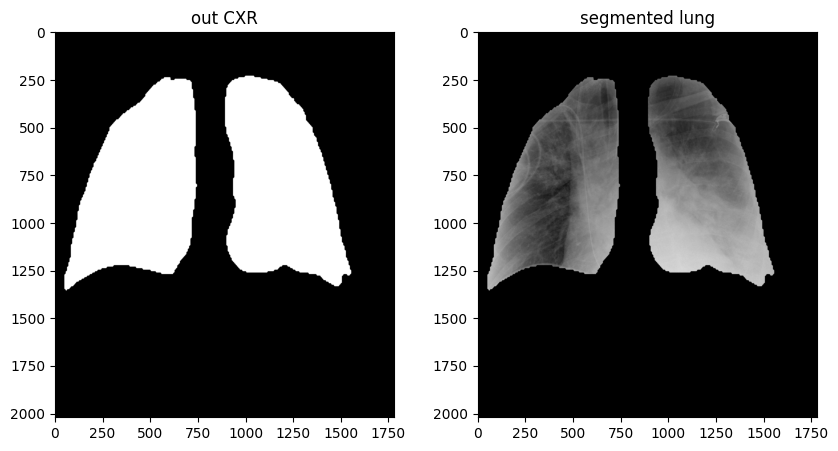

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
origin1 = Image.open(image_path)
origin = Image.open(image_path).convert("L")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin1 = torchvision.transforms.functional.to_tensor(origin1)
height = origin1.shape[1]
width = origin1.shape[2]

with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)

    origin = origin[0].to("cpu")
    out = out[0].to("cpu")
    plt.figure(figsize=(10, 5))

    # plt.imshow(origin_reshape1)
    out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
    threshold = 0.5
    out_upsample = (out_upsample > threshold).float()
    print("out_upsample =", out_upsample.shape)

    plt.subplot(1, 2, 1)
    plt.title("out CXR")
    out_reshape = torch.permute(out_upsample,(1,2,0))
    out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
    plt.imshow(out_reshape1)

    plt.subplot(1, 2, 2)
    plt.title("segmented lung")
    origin_reshape = torch.permute(origin1,(1,2,0))
    print("shape of out_reshape = ",origin_reshape.shape)
    segmented_lung = out_reshape1 * origin_reshape
    plt.imshow(segmented_lung);

In [ ]:
segmented_lung.shape

torch.Size([2020, 1780, 3])

In [ ]:
y1 = torch.min(out_reshape.nonzero()[:,0])
y2 = torch.max(out_reshape.nonzero()[:,0])
x1 = torch.min(out_reshape.nonzero()[:,1])
x2 = torch.max(out_reshape.nonzero()[:,1])
print(y1,y2,x1,x2)

tensor(229) tensor(1356) tensor(49) tensor(1550)


torch.Size([1127, 1501, 3])


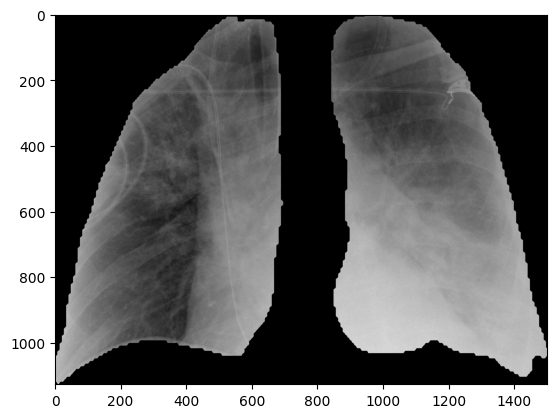

In [ ]:
cropped_lung = segmented_lung[y1:y2,x1:x2,:]
print(cropped_lung.shape)
plt.imshow(cropped_lung)

In [ ]:
import csv

# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/Datasets/cropping_data1.csv'

# Write the data to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['image_name', 'folder', 'x', 'y', 'width', 'height'])
    writer.writeheader()
    for i in range(5):
      data = [
      {'image_name': 'image1.jpg', 'folder': 'folder1', 'x': 10, 'y': 20, 'width': 100*i, 'height': 100},
      {'image_name': 'image2.jpg', 'folder': 'folder2', 'x': 50, 'y': 60, 'width': 150, 'height': 200},
      ]
      writer.writerows(data)


FileNotFoundError: ignored

In [ ]:
arr = os.listdir("/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS")

KeyboardInterrupt: ignored

# Inference from Individual Folders of UPMC data

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC-ARDS" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC-ARDS/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path)
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape
        if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
          y1 = torch.min(out_reshape.nonzero()[:,0])
          y2 = torch.max(out_reshape.nonzero()[:,0])
          x1 = torch.min(out_reshape.nonzero()[:,1])
          x2 = torch.max(out_reshape.nonzero()[:,1])
        else:
          y1 = 0
          y2 = 0
          x1 = 0
          x2 = 0
        #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
        image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
        save_path = os.path.join(save_dir_lung, image_name)
        image.save(save_path)

       # Write the data to the CSV file
        data = [
        {'folder': 'UPMC-ARDS', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
        ]
        writer.writerows(data)

        # pil_origin = torchvision.transforms.functional.to_pil_image(origin).convert("RGB")
        # input_cxr = np.array(pil_origin)
        # # pdb.set_trace()
        # out1 = np.array(np.repeat(out,3,1).reshape(256,256,3)) # out 1 is the mask
        # segmented_lung = (np.array(pil_origin) * out1).astype(np.uint8)
        # # cat_image = np.concatenate((input_cxr, segmented_lung), axis = 1)
        # # im1 = Image.fromarray(cat_image)
        # im1 = Image.fromarray(segmented_lung)
        # save_path = os.path.join(save_dir_lung, image_name)
        # im1.save(save_path)
        # im2 = Image.fromarray(np.array(out*255).astype(np.uint8))
        # save_path = os.path.join(save_dir_mask, image_name)
        # im2.save(save_path)

100%|██████████| 492/492 [11:54<00:00,  1.45s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ProCopi-V2.1.0-V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC-ProCopi-V2.1.0-V2.1.3" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC-ProCopi-V2.1.0-V2.1.3/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    # print("shape of origin =",origin.shape)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    # print("shape of origin1 =",origin1.shape)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        # print("shape of out_upsample =",out_upsample.shape)
        out_reshape = torch.permute(out_upsample,(1,2,0))
        # print("shape of out_reshape =",out_reshape.shape)
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        # print("shape of out_reshape1 =",out_reshape1.shape)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape
        if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
          y1 = torch.min(out_reshape.nonzero()[:,0])
          y2 = torch.max(out_reshape.nonzero()[:,0])
          x1 = torch.min(out_reshape.nonzero()[:,1])
          x2 = torch.max(out_reshape.nonzero()[:,1])
        else:
          y1 = 0
          y2 = 0
          x1 = 0
          x2 = 0
        #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
        image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
        save_path = os.path.join(save_dir_lung, image_name)
        image.save(save_path)

       # Write the data to the CSV file
        data = [
        {'folder': 'UPMC-ProCopi-V2.1.0-V2.1.3', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
        ]
        writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 144/144 [03:22<00:00,  1.41s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ALIR_V2.0.1" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ALIR_V2.0.1/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ALIR_V2.0.1', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 98/98 [04:52<00:00,  2.98s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ALIR_V2.0.2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ALIR_V2.0.2/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ALIR_V2.0.2', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 63/63 [03:49<00:00,  3.64s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.1" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.1/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ARDS_V2.2.1', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 116/116 [03:17<00:00,  1.70s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.2/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ARDS_V2.2.2', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 115/115 [02:50<00:00,  1.48s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.3" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.3/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ARDS_V2.2.3', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 117/117 [02:51<00:00,  1.47s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.4" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ARDS_V2.2.4/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ARDS_V2.2.4', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 112/112 [04:06<00:00,  2.20s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_Floor_V2.1.4" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_Floor_V2.1.4/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_Floor_V2.1.4', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 98/98 [05:14<00:00,  3.21s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.5" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_Floor_V2.1.5" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_Floor_V2.1.5/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_Floor_V2.1.5', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 41/41 [02:03<00:00,  3.00s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi2/Images" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi2/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ProCopi2', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 191/191 [03:02<00:00,  1.05it/s]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.0" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.0" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.0/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ProCopi_V2.1.0', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.1" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.1/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ProCopi_V2.1.1', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.2/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ProCopi_V2.1.2', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


100%|██████████| 47/47 [01:15<00:00,  1.60s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.3" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.3/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ProCopi_V2.1.3', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 47/47 [01:09<00:00,  1.47s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.6" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.6" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/UPMC_ProCopi_V2.1.6/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape
          if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
            y1 = torch.min(out_reshape.nonzero()[:,0])
            y2 = torch.max(out_reshape.nonzero()[:,0])
            x1 = torch.min(out_reshape.nonzero()[:,1])
            x2 = torch.max(out_reshape.nonzero()[:,1])
          else:
            y1 = 0
            y2 = 0
            x1 = 0
            x2 = 0
          #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
          image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
          save_path = os.path.join(save_dir_lung, image_name)
          image.save(save_path)

        # Write the data to the CSV file
          data = [
          {'folder': 'UPMC_ProCopi_V2.1.6', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
          ]
          writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 191/191 [02:59<00:00,  1.07it/s]


## Cleaveland clinic images

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID"
arr = os.listdir(image_dir)
print(len(arr))

1117


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/CCF_COVID" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
# Specify the CSV file path
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_resized/CCF_COVID/cropping_data.csv'
with open(csv_file, 'w', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['folder', 'image_name', 'x1', 'x2', 'y1', 'y2'])
  writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    #if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape
        if out_reshape.nonzero().nelement() != 0: # handling output lungs which is filled with zeros
          y1 = torch.min(out_reshape.nonzero()[:,0])
          y2 = torch.max(out_reshape.nonzero()[:,0])
          x1 = torch.min(out_reshape.nonzero()[:,1])
          x2 = torch.max(out_reshape.nonzero()[:,1])
        else:
          y1 = 0
          y2 = 0
          x1 = 0
          x2 = 0
        #cropped_lung = segmented_lung[y1:y2,x1:x2,:]
        image = Image.fromarray((segmented_lung * 255).numpy().astype(np.uint8))
        save_path = os.path.join(save_dir_lung, image_name)
        image.save(save_path)

      # Write the data to the CSV file
        data = [
        {'folder': 'CCF_COVID', 'image_name': image_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)},
        ]
        writer.writerows(data)


new save directory created for resized lung segmentation


100%|██████████| 1117/1117 [21:18<00:00,  1.14s/it]


In [ ]:
import numpy as np
from PIL import Image

# Load the PNG image using PIL
image_pil = Image.open('/content/drive/MyDrive/Projects/Pulsar-AI/Datasets/v7_cxr/cxr/959789.png')

# Convert the PIL image to a NumPy array
image_np = np.array(image_pil)

# Print the shape and data type of the NumPy array
print('Shape:', image_np.shape)
print('Data type:', image_np.dtype)

Shape: (598, 763, 3)
Data type: uint8


## Add wires to xrays

(4072, 4952, 3)


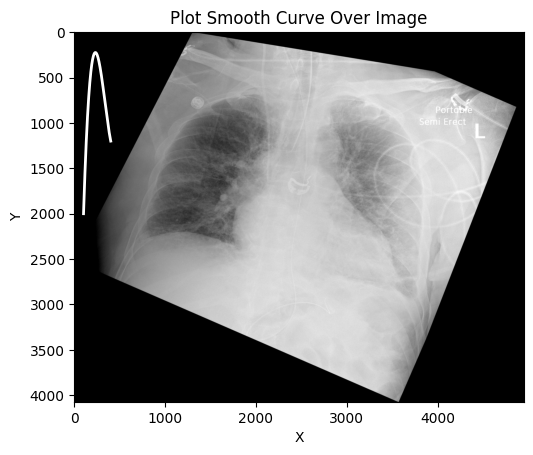

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.1/05096_200418.png"  # Replace with the actual path to your image
image = plt.imread(image_path)
print(image.shape)

# Dataset
x = np.array([100, 200, 300, 400])
y = np.array([2000, 300, 500, 1200])

X_Y_Spline = make_interp_spline(x, y)

# Returns evenly spaced numbers over a specified interval
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Plot the image
plt.imshow(image)

# Plot the smooth curve on top of the image
plt.plot(X_, Y_, color = (1,1,1), linewidth=2.0)

plt.title("Plot Smooth Curve Over Image")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [ ]:
np.cos(0)

1.0

translation =  71.06705536342184 54.29341826204958
0.4411897026837053 2.017970543237907 0.6307135378909223 -4.911962043848185
theta [2.00506695]
translation =  48.03570895700291 37.09161867349033
4.271280104677041 4.453027305469584 3.953593492297177 -1.4546324612951533
theta [1.21132494]
translation =  1.405236031489121 30.053357788793434
-1.6088372647554117 1.2084721996892833 4.793581137222479 0.14310245978226166
theta [0.27611055]


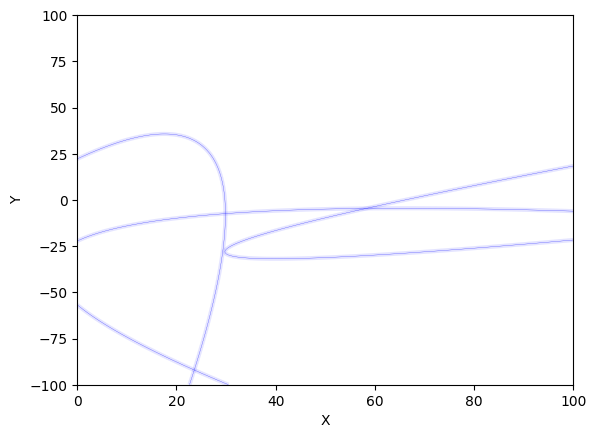

In [ ]:
x = np.linspace(0, 100, 1000)
y = np.linspace(-100, 100, 1000)
X, Y = np.meshgrid(x, y)
for i in range (3):
  a,b,c,d = (np.random.rand(4)-0.5)*10
  x1, y1 = np.random.uniform(low=0.0, high=100.0, size=(2))
  print("translation = ",x1,y1)
  # a,b,c,d = [1,1,1,1]
  print(a,b,c,d)
  theta = np.random.rand(1)*3
  print("theta", theta)

  # add rotation
  Xx = X*np.cos(theta) - Y*np.sin(theta)
  Yy = X*np.sin(theta) + Y*np.cos(theta)
  # add translation
  Xx = Xx - x1
  Yy = Yy - y1
  # parabola equation
  Z = (Yy) - a/20*(Xx)**2 - b*(Xx) - c #dividing a/20 to get wider parabola
  plt.contour(X, Y, Z, levels=[0], colors='blue', alpha = 0.8, linewidths = 0.2)
  plt.contour(X, Y, Z, levels=[0], colors='blue', alpha = 0.1, linewidths = 3)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
 image = Image.open("/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr0.jpeg")

In [ ]:
image_np = np.array(image)

In [ ]:
image_np.shape

(3056, 2544)

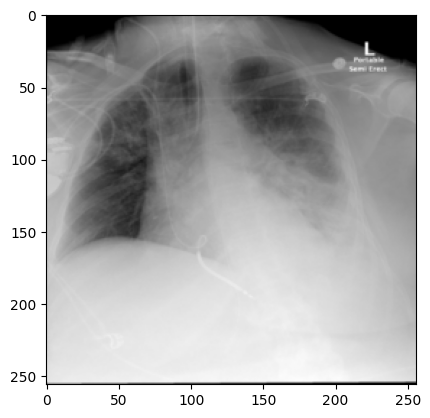

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr3.png"
origin = Image.open(image_path).convert("RGB")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin = torch.permute(origin,(1,2,0))
plt.imshow(origin)
plt.show()

translation =  149.492790493396 145.98180545302296
1.6687715797323521 -0.5450147140704786 -1.5241705289579566 -4.909886374439481
theta [1.53076482]
translation =  158.00227312804492 148.52284095822247
3.361546816325125 1.3797592151204396 2.1437574474950463 -3.7495957876030452
theta [1.79405162]
translation =  19.7156420519181 77.53956268805143
3.508013127479331 -3.3362239899674453 2.565802552723339 4.005398689736336
theta [2.36415588]
translation =  56.73147449356969 191.1354923410805
4.454081778873981 1.3496877864479284 3.2310730612121707 4.124109879849779
theta [0.75124813]


NameError: ignored

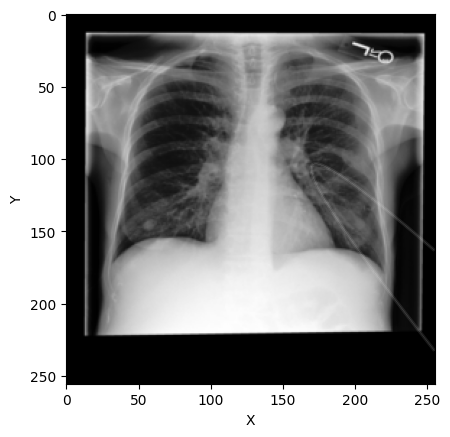

In [ ]:
image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr0.jpeg"
origin = Image.open(image_path).convert("RGB")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin = torch.permute(origin,(1,2,0))
# plt.imshow(origin)
x = np.linspace(0, 255, 1000)
y = np.linspace(0, 255, 1000)
X, Y = np.meshgrid(x, y)
for i in range (4):
  a,b,c,d = (np.random.rand(4)-0.5)*10
  # x1, y1 = np.random.uniform(low=0.0, high=255.0, size=(2))
  x1, y1 = np.random.rand(2)*255
  print("translation = ",x1,y1)
  # a,b,c,d = [1,1,1,1]
  print(a,b,c,d)
  theta = np.random.rand(1)*3
  print("theta", theta)

  # add rotation
  Xx = X*np.cos(theta) - Y*np.sin(theta)
  Yy = X*np.sin(theta) + Y*np.cos(theta)
  # Xx = X
  # Yy = Y
  # add translation
  Xx = Xx - x1
  Yy = Yy - y1
  # parabola equation
  Z = (Yy) - a/20*(Xx)**2 - b*(Xx) - c #dividing a/20 to get wider parabola
  plt.contour(X, Y, Z, levels=[0], colors='white', alpha = 0.3, linewidths = 0.2)
  plt.contour(X, Y, Z, levels=[0], colors='white', alpha = 0.1, linewidths = 2.5)
  plt.imshow(origin)
  plt.savefig("/content/drive/MyDrive/Projects/Pulsar-AI/images/tubes.png")
plt.xlabel('X')
plt.ylabel('Y')
# plt.show()

#Save plt to array
# Make a random plot...

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
fig.canvas.draw()

# Now we can save it to a numpy array.
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# plt.imshow(origin)
# plt.show()

In [ ]:
np.unique(data)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Open the image using plt.imread()
image = plt.imread(image_path)

# Display the image on the axis
ax.imshow(image)


image_path = "/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master/images/cxr_test/cxr0.jpeg"
origin = Image.open(image_path).convert("RGB")
origin = torchvision.transforms.functional.resize(origin, (256, 256))
origin = torchvision.transforms.functional.to_tensor(origin)
origin = torch.permute(origin,(1,2,0))
# plt.imshow(origin)
x = np.linspace(0, 255, 1000)
y = np.linspace(0, 255, 1000)
X, Y = np.meshgrid(x, y)
for i in range (4):
  a,b,c,d = (np.random.rand(4)-0.5)*10
  # x1, y1 = np.random.uniform(low=0.0, high=255.0, size=(2))
  x1, y1 = np.random.rand(2)*255
  print("translation = ",x1,y1)
  # a,b,c,d = [1,1,1,1]
  print(a,b,c,d)
  theta = np.random.rand(1)*3
  print("theta", theta)

  # add rotation
  Xx = X*np.cos(theta) - Y*np.sin(theta)
  Yy = X*np.sin(theta) + Y*np.cos(theta)
  # Xx = X
  # Yy = Y
  # add translation
  Xx = Xx - x1
  Yy = Yy - y1
  # parabola equation
  Z = (Yy) - a/20*(Xx)**2 - b*(Xx) - c #dividing a/20 to get wider parabola
  plt.contour(X, Y, Z, levels=[0], colors='white', alpha = 0.3, linewidths = 0.2)
  plt.contour(X, Y, Z, levels=[0], colors='white', alpha = 0.1, linewidths = 2.5)
  plt.imshow(origin)
  plt.savefig("/content/drive/MyDrive/Projects/Pulsar-AI/images/tubes.png")
plt.grid(False)
plt.axis('off')
plt.show()



In [ ]:
#Save plt to array
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# plt.imshow(origin)
# plt.show()

In [ ]:
np.unique(data)